## Part 3 - Feature Engineering and Modelling

### Author: Johann Manukulasuriya

#### BrainStation, Fall 2021 Cohort

#### Order of Notebook

1. Basic EDA
2. Feature Engineering
3. Data Splitting
4. Modelling
    - Logistic Regression
    - KNN
    - Decision Trees
    - SVM
5. Conclusions

In this third part, I will be working on the cleaned dataset. I will be binarzing the target column - `recommended` - which indicates that my modelling will be focused on binary classification.

The modelling process will also involve One Hot Encoding the `Customer_Review` column to extract 'tokens' (individualized words) that will be crucial in creating my machine learning models that could correctly predict which reviews were a 'Yes'/'No' recommendation.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import libraries
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report

We can now read in the cleaned dataset that was produced from the Preprocessing and Cleaning notebook.

In [2]:
# Read in the dataset
airlines = pd.read_csv('airlines_data_cleaned_finalized.csv')
airlines.head()

,airline,overall,customer_review,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,origin,destination,week_of_year,month_of_year,year,day_of_month
0,Turkish Airlines,7,✅ Trip Verified | London to Izmir via Istanbul...,Business,Economy Class,4,5,4,4,2,4,yes,London,Izmir,19,5,2019,8
1,Turkish Airlines,2,✅ Trip Verified | Istanbul to Bucharest. We ma...,Family Leisure,Economy Class,4,1,1,1,1,1,no,Istanbul,Bucharest,19,5,2019,7
2,Turkish Airlines,3,✅ Trip Verified | Rome to Prishtina via Istanb...,Business,Economy Class,1,4,1,3,1,2,no,Rome,Prishtina,19,5,2019,7
3,Turkish Airlines,10,✅ Trip Verified | Flew on Turkish Airlines IAD...,Solo Leisure,Economy Class,4,5,5,5,5,5,yes,Washington Dulles,Karachi,19,5,2019,6
4,Turkish Airlines,1,✅ Trip Verified | Mumbai to Dublin via Istanbu...,Solo Leisure,Economy Class,1,1,1,1,1,1,no,Mumbai,Dublin,19,5,2019,6


The first step here is to convert the `recommended` column into binary values.

### 1. Basic EDA

In [3]:
# Convert recommended variable to binary
airlines['recommended'] = np.where(airlines['recommended'] == 'yes', 1, 0)

In [4]:
# Check
airlines.head()

,airline,overall,customer_review,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,origin,destination,week_of_year,month_of_year,year,day_of_month
0,Turkish Airlines,7,✅ Trip Verified | London to Izmir via Istanbul...,Business,Economy Class,4,5,4,4,2,4,1,London,Izmir,19,5,2019,8
1,Turkish Airlines,2,✅ Trip Verified | Istanbul to Bucharest. We ma...,Family Leisure,Economy Class,4,1,1,1,1,1,0,Istanbul,Bucharest,19,5,2019,7
2,Turkish Airlines,3,✅ Trip Verified | Rome to Prishtina via Istanb...,Business,Economy Class,1,4,1,3,1,2,0,Rome,Prishtina,19,5,2019,7
3,Turkish Airlines,10,✅ Trip Verified | Flew on Turkish Airlines IAD...,Solo Leisure,Economy Class,4,5,5,5,5,5,1,Washington Dulles,Karachi,19,5,2019,6
4,Turkish Airlines,1,✅ Trip Verified | Mumbai to Dublin via Istanbu...,Solo Leisure,Economy Class,1,1,1,1,1,1,0,Mumbai,Dublin,19,5,2019,6


Now wer can create a smaller dataframe consisting of airlines of a select region. I will be creating a dataframe consisting of Middle Eastern carriers, and unlike the analysis in the EDA notebook that consisted of only 6 carriers, here I will be including all Middle Eastern carriers.

In [5]:
# Check unique number of airlines
airlines['airline'].unique()

array(['Turkish Airlines', 'Qatar Airways', 'Emirates', 'Lufthansa',
       'KLM Royal Dutch Airlines', 'Virgin America', 'American Airlines',
       'Delta Air Lines', 'Southwest Airlines', 'United Airlines',
       'Jetblue Airways', 'Aegean Airlines', 'Aeroflot Russian Airlines',
       'Aeromexico', 'Air Canada', 'Air New Zealand', 'Alitalia',
       'AirAsia', 'Asiana Airlines', 'Avianca', 'Austrian Airlines',
       'British Airways', 'Brussels Airlines', 'China Eastern Airlines',
       'China Southern Airlines', 'Copa Airlines', 'Ethiopian Airlines',
       'Egyptair', 'Finnair', 'Iberia', 'ANA All Nippon Airways',
       'easyJet', 'Korean Air', 'LATAM Airlines', 'LOT Polish Airlines',
       'Qantas Airways', 'Air France', 'Etihad Airways',
       'Pegasus Airlines', 'Royal Jordanian Airlines', 'Ryanair',
       'South African Airways', 'Saudi Arabian Airlines', 'TAP Portugal',
       'Eurowings', 'EVA Air', 'Royal Air Maroc', 'Singapore Airlines',
       'SAS Scandinavian', 

For the Middle Eastern dataframe, the following airlines will be selected - Emirates, Turkish Airlines, Qatar Airways, Egyptair, Etihad Airways, Royal Jordanian Airlines, flydubai, Saudi Arabian Airlines, Air Arabia, Gulf Air, and Kuwait Airways.

In [6]:
# Create a North American airline dataframe
me_airlines = airlines[(airlines['airline'] == 'Turkish Airlines') | (airlines['airline'] == 'Qatar Airways')
                      | (airlines['airline'] == 'Egyptair') | (airlines['airline'] == 'Etihad Airways')
                      | (airlines['airline'] == 'Royal Jordanian Airlines') | (airlines['airline'] == 'flydubai')
                      | (airlines['airline'] == 'Saudi Arabian Airlines') | (airlines['airline'] == 'Air Arabia') 
                      | (airlines['airline'] == 'Gulf Air') | (airlines['airline'] == 'Kuwait Airways')
                       | (airlines['airline'] == 'Emirates')
                      ]

In [7]:
# Check shape of new dataframe
me_airlines.shape

(4598, 18)

Save the Middle Eastern Airlines dataframe as its own CSV file.


In [8]:
me_airlines.to_csv('me_airlines.csv', index=False)

I have a nice 3480 row by 18 column dataframe consisting of Middle Eastern carriers. Before we begin One-Hot Encoding the categorical variables, let's have a quick look at the target column to check if there's any class imbalance. 

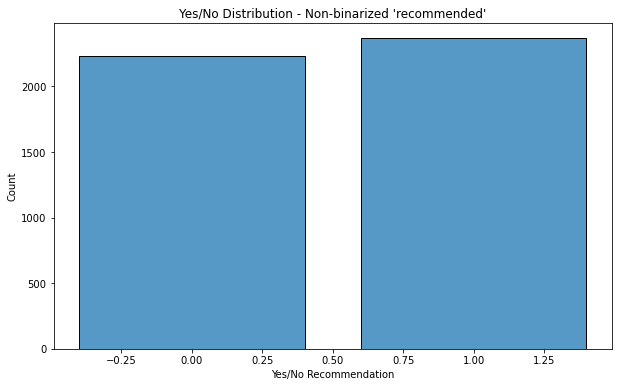

In [9]:
recommended_totals = me_airlines['recommended']

plt.figure(figsize=(10,6))
sns.histplot(x=recommended_totals, discrete=True, shrink=0.8)
plt.xlabel('Yes/No Recommendation')
plt.ylabel('Count')
plt.title("Yes/No Distribution - Non-binarized 'recommended'")

plt.show()

I can see there isn't any significant class imbalance between the 'Yes Recommend' (1) and 'No Recommend' (0).

SIDE NOTE: Please don't mark this code below. It's code I plan to keep for later iterations!

In [10]:
#def classify_score(me_airlines_row):
#    """
#    INPUT: 
#    row
#    
#    OUTPUT:
#    - positive if the overall score is >=7
#    - neutral if the overall score is 5 or 6
#    - negative if the overall score is <= 4
#    """
#    
#    if (me_airlines_row['overall'] <= 4):
#        classify_score = 'negative'
#    elif (me_airlines_row['overall'] > 4 and me_airlines_row['overall'] <=6):
#       classify_score = 'neutral'
#    else:
#        classify_score = 'positive'
#        
#    return classify_score

# me_airlines['classify_experience'] = me_airlines.apply(lambda x: classify_score(x), axis=1)

I can now move onto One-Hot Encoding the categorical columns - `airline`, `cabin`, `traveller_type`, `origin` and `destination` - to get my dataframe ready for modelling.

### 2. Feature Engineering

Time to One-Hot Encode the categorical variables!

#### `Airline`

In [11]:
# Using OneHotEncoder to encode the airline column
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the bookings column and transform
# Expects a 2D array
me_airlines_df = pd.DataFrame(me_airlines['airline'])
ohe_me_airline = ohe.fit_transform(me_airlines_df)

ohe_me_airline

<4598x11 sparse matrix of type '<class 'numpy.float64'>'
	with 4598 stored elements in Compressed Sparse Row format>

Thanks to One-Hot Encoding, I now have a sparse matrix that has the same number of rows as my North American carrier dataset, but now with 10 new airline columns.

In [12]:
# Convert the sparse matrix to a dense matrix
ohe_me_airline_dense = ohe_me_airline.toarray()

me_airlines_df = pd.DataFrame(ohe_me_airline_dense, columns=ohe.categories_[0]).astype('int')

In [13]:
# Inspect the airline columns
me_airlines_df.head()

,Air Arabia,Egyptair,Emirates,Etihad Airways,Gulf Air,Kuwait Airways,Qatar Airways,Royal Jordanian Airlines,Saudi Arabian Airlines,Turkish Airlines,flydubai
0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,0


Add the dataframe above to the `na_airlines` dataframe.

In [14]:
me_airlines = pd.concat([me_airlines, me_airlines_df.set_index(me_airlines.index)], axis=1)

I can now drop the original `airline` column.

In [15]:
me_airlines.drop(columns='airline', inplace=True)

# Check
me_airlines.head()

,overall,customer_review,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,Egyptair,Emirates,Etihad Airways,Gulf Air,Kuwait Airways,Qatar Airways,Royal Jordanian Airlines,Saudi Arabian Airlines,Turkish Airlines,flydubai
0,7,✅ Trip Verified | London to Izmir via Istanbul...,Business,Economy Class,4,5,4,4,2,4,...,0,0,0,0,0,0,0,0,1,0
1,2,✅ Trip Verified | Istanbul to Bucharest. We ma...,Family Leisure,Economy Class,4,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
2,3,✅ Trip Verified | Rome to Prishtina via Istanb...,Business,Economy Class,1,4,1,3,1,2,...,0,0,0,0,0,0,0,0,1,0
3,10,✅ Trip Verified | Flew on Turkish Airlines IAD...,Solo Leisure,Economy Class,4,5,5,5,5,5,...,0,0,0,0,0,0,0,0,1,0
4,1,✅ Trip Verified | Mumbai to Dublin via Istanbu...,Solo Leisure,Economy Class,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0


I have successfully One-Hot Encoded the `airline` column and dropped it. Let's take care of the `traveller_type` variable next.

#### `traveller_type`

In [16]:
# Fit the OneHotEncoder to the bookings column and transform
me_traveller_df = pd.DataFrame(me_airlines['traveller_type'])
ohe_me_traveller_df = ohe.fit_transform(me_traveller_df)

ohe_me_traveller_df

<4598x4 sparse matrix of type '<class 'numpy.float64'>'
	with 4598 stored elements in Compressed Sparse Row format>

In [17]:
# Convert the sparse matrix to a dense matrix
ohe_me_traveller_dense = ohe_me_traveller_df.toarray()

me_traveller_df = pd.DataFrame(ohe_me_traveller_dense, columns=ohe.categories_[0]).astype('int')

# Inspect
me_traveller_df.head()

,Business,Couple Leisure,Family Leisure,Solo Leisure
0,1,0,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


I can now add this dataframe to my North American carriers dataframe.

In [18]:
me_airlines = pd.concat([me_airlines, me_traveller_df.set_index(me_airlines.index)], axis=1)

It's time to drop the `traveller_type` column.

In [19]:
me_airlines.drop(columns='traveller_type', inplace=True)

In [20]:
# Check
me_airlines.head(2)

,overall,customer_review,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,...,Kuwait Airways,Qatar Airways,Royal Jordanian Airlines,Saudi Arabian Airlines,Turkish Airlines,flydubai,Business,Couple Leisure,Family Leisure,Solo Leisure
0,7,✅ Trip Verified | London to Izmir via Istanbul...,Economy Class,4,5,4,4,2,4,1,...,0,0,0,0,1,0,1,0,0,0
1,2,✅ Trip Verified | Istanbul to Bucharest. We ma...,Economy Class,4,1,1,1,1,1,0,...,0,0,0,0,1,0,0,0,1,0


Next will be the `cabin` variable.

#### `cabin`

In [21]:
# Fit the OneHotEncoder to the bookings column and transform
me_cabin_df = pd.DataFrame(me_airlines['cabin'])
ohe_me_cabin_df = ohe.fit_transform(me_cabin_df)

ohe_me_cabin_df

<4598x4 sparse matrix of type '<class 'numpy.float64'>'
	with 4598 stored elements in Compressed Sparse Row format>

In [22]:
# Convert the sparse matrix to a dense matrix
ohe_me_cabin_dense = ohe_me_cabin_df.toarray()

me_cabin_df = pd.DataFrame(ohe_me_cabin_dense, columns=ohe.categories_[0]).astype('int')

# Inspect
me_cabin_df.head()

,Business Class,Economy Class,First Class,Premium Economy
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


I can now add this dataframe to my North American carriers dataframe.

In [23]:
me_airlines = pd.concat([me_airlines, me_cabin_df.set_index(me_airlines.index)], axis=1)

# Drop old cabin column
me_airlines.drop(columns='cabin', inplace=True)

# Check
me_airlines.head()

,overall,customer_review,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,origin,...,Turkish Airlines,flydubai,Business,Couple Leisure,Family Leisure,Solo Leisure,Business Class,Economy Class,First Class,Premium Economy
0,7,✅ Trip Verified | London to Izmir via Istanbul...,4,5,4,4,2,4,1,London,...,1,0,1,0,0,0,0,1,0,0
1,2,✅ Trip Verified | Istanbul to Bucharest. We ma...,4,1,1,1,1,1,0,Istanbul,...,1,0,0,0,1,0,0,1,0,0
2,3,✅ Trip Verified | Rome to Prishtina via Istanb...,1,4,1,3,1,2,0,Rome,...,1,0,1,0,0,0,0,1,0,0
3,10,✅ Trip Verified | Flew on Turkish Airlines IAD...,4,5,5,5,5,5,1,Washington Dulles,...,1,0,0,0,0,1,0,1,0,0
4,1,✅ Trip Verified | Mumbai to Dublin via Istanbu...,1,1,1,1,1,1,0,Mumbai,...,1,0,0,0,0,1,0,1,0,0


Let's do the same process for the `origin` column.

#### `origin`

In [24]:
# Fit the OneHotEncoder to the bookings column and transform
me_origin_df = pd.DataFrame(me_airlines['origin'])
ohe_me_origin_df = ohe.fit_transform(me_origin_df)

ohe_me_origin_df

<4598x437 sparse matrix of type '<class 'numpy.float64'>'
	with 4598 stored elements in Compressed Sparse Row format>

In [25]:
# Convert the sparse matrix to a dense matrix
ohe_me_origin_dense = ohe_me_origin_df.toarray()

me_origin_df = pd.DataFrame(ohe_me_origin_dense, columns=ohe.categories_[0]).astype('int')

# Inspect
me_origin_df.head()

,ABJ,ABV,ACC,ADD,ADL,AGP,ALA,ALG,AMD,AMM,...,ZAG,Zagreb,Zanzibar,Zurich,Zürich,cape town,istambul,istanbul,manchester,İstanbul
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
me_airlines = pd.concat([me_airlines, me_origin_df.set_index(me_airlines.index)], axis=1)

# Drop old cabin column
me_airlines.drop(columns='origin', inplace=True)

# Check
me_airlines.head()

,overall,customer_review,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,destination,...,ZAG,Zagreb,Zanzibar,Zurich,Zürich,cape town,istambul,istanbul,manchester,İstanbul
0,7,✅ Trip Verified | London to Izmir via Istanbul...,4,5,4,4,2,4,1,Izmir,...,0,0,0,0,0,0,0,0,0,0
1,2,✅ Trip Verified | Istanbul to Bucharest. We ma...,4,1,1,1,1,1,0,Bucharest,...,0,0,0,0,0,0,0,0,0,0
2,3,✅ Trip Verified | Rome to Prishtina via Istanb...,1,4,1,3,1,2,0,Prishtina,...,0,0,0,0,0,0,0,0,0,0
3,10,✅ Trip Verified | Flew on Turkish Airlines IAD...,4,5,5,5,5,5,1,Karachi,...,0,0,0,0,0,0,0,0,0,0
4,1,✅ Trip Verified | Mumbai to Dublin via Istanbu...,1,1,1,1,1,1,0,Dublin,...,0,0,0,0,0,0,0,0,0,0


And finally, we have the `destination` variable.

#### `destination`

In [27]:
# Fit the OneHotEncoder to the bookings column and transform
me_destination_df = pd.DataFrame(me_airlines['destination'])
ohe_me_destination_df = ohe.fit_transform(me_destination_df)

ohe_me_destination_df

<4598x451 sparse matrix of type '<class 'numpy.float64'>'
	with 4598 stored elements in Compressed Sparse Row format>

In [28]:
# Convert the sparse matrix to a dense matrix
ohe_me_destination_dense = ohe_me_destination_df.toarray()

me_destination_df = pd.DataFrame(ohe_me_destination_dense, columns=ohe.categories_[0]).astype('int')

# Inspect
me_destination_df.head()

,ABV,ACC,ADB,ADD,ADL,AGP,AIUH,ALA,AMD,AMM,...,ZAG,Zagreb,Zanzibar,Zurich,bodrum,brussels,cairo,dxb,goa,İstanbul
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
me_airlines = pd.concat([me_airlines, me_destination_df.set_index(me_airlines.index)], axis=1)

# Drop old cabin column
me_airlines.drop(columns='destination', inplace=True)

# Check
me_airlines.head()

,overall,customer_review,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,week_of_year,...,ZAG,Zagreb,Zanzibar,Zurich,bodrum,brussels,cairo,dxb,goa,İstanbul
0,7,✅ Trip Verified | London to Izmir via Istanbul...,4,5,4,4,2,4,1,19,...,0,0,0,0,0,0,0,0,0,0
1,2,✅ Trip Verified | Istanbul to Bucharest. We ma...,4,1,1,1,1,1,0,19,...,0,0,0,0,0,0,0,0,0,0
2,3,✅ Trip Verified | Rome to Prishtina via Istanb...,1,4,1,3,1,2,0,19,...,0,0,0,0,0,0,0,0,0,0
3,10,✅ Trip Verified | Flew on Turkish Airlines IAD...,4,5,5,5,5,5,1,19,...,0,0,0,0,0,0,0,0,0,0
4,1,✅ Trip Verified | Mumbai to Dublin via Istanbu...,1,1,1,1,1,1,0,19,...,0,0,0,0,0,0,0,0,0,0


In [30]:
me_airlines.shape

(4598, 920)

With the categorical variables all converted to binary using One-Hot Encoding, we can move onto extracting the positive and negative sentiment related words from the Middle Eastern carrier dataframe. 

Before I begin modelling, I'd like to extract the positive and negative words that are associated with 'Yes' recommended flights, and 'No' recommended flights. I will be creating a temporary X and temporary y variable for this section which I will not use during my modelling section.

The independent X1 variable will contain only the `customer_review` column while the y1 variable will contain the target column, the `recommended` column. I will also be comparing the `CountVectorizer()` and `TfidfVectorizer()` to see if I get similar negative/positive experience words.

##### `CountVectorizer()`

In [30]:
X1 = me_airlines['customer_review']
y1 = me_airlines['recommended']

In [31]:
# Perform a train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, 
                                                    test_size=0.33, 
                                                    stratify=y1,
                                                    random_state=42)

In [32]:
bagofwords_count = CountVectorizer(stop_words="english")
bagofwords_count.fit(X1_train)

X1_train_transformed = bagofwords_count.transform(X1_train) 
X1_test_transformed = bagofwords_count.transform(X1_test) 

X1_train_transformed.shape

(3080, 12533)

In [33]:
words = bagofwords_count.get_feature_names()
word_counts = X1_train_transformed.toarray().sum(axis=0)

D:\UDemy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X1_train_transformed, y1_train)

# Training and test score
print(f"Train score: {logreg.score(X1_train_transformed, y1_train)}")
print(f"Test score: {logreg.score(X1_test_transformed, y1_test)}")

Train score: 0.9707792207792207
Test score: 0.8728590250329381


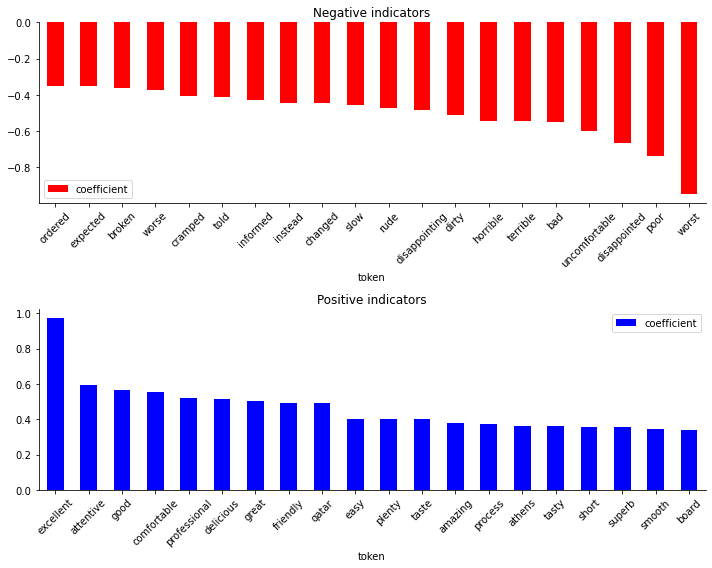

In [35]:
def plot_coefs(logreg, words):
    coef_df = pd.DataFrame({"coefficient": logreg.coef_[0], "token": words})
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # smallest coefficient -> tokens indicating negative sentiment 
    coef_df.tail(20).set_index("token").plot(kind="bar", rot=45, ax=axs[0], color="red")
    axs[0].set_title("Negative indicators")
 
    
    # largest coefficient -> tokens indicating positive sentiment 
    coef_df.head(20).set_index("token").plot(kind="bar", rot=45, ax=axs[1], color="blue")
    axs[1].set_title("Positive indicators")
    
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
plot_coefs(logreg, words)

The words most commonly used for a negative review (No Recommend) appear to be - worst, poor, bad, horrible, etc. This is a good start, as the model appears capable of recognizing reviews that led to a 'No Recommend'. 

It's the same situation for the most commonly used words for a positive review (Yes recommend), with words like excellent, great, good, and attentive being recognized.

Next, let's produce a dataframe containing the top 20 positive/negative sentiment words for Middle Eastern carriers.

In [36]:
# Create the coefficients dataframe
coef_df = pd.DataFrame({"coefficient": logreg.coef_[0], "token": words})
coef_df = coef_df.sort_values("coefficient", ascending=False)

In [37]:
# Create dataframes for the top 20 positive/negative words
coef_df_pos = coef_df.head(20)
coef_df_neg = coef_df.tail(20)

In [38]:
coef_df_pos

,coefficient,token
4608,0.973384,excellent
1536,0.594991,attentive
5421,0.567965,good
2829,0.556180,comfortable
8791,0.522340,professional
3595,0.512808,delicious
5483,0.501427,great
5204,0.490092,friendly
8946,0.489451,qatar
4214,0.403571,easy


In [39]:
coef_df_neg

,coefficient,token
7986,-0.350568,ordered
4666,-0.350877,expected
2172,-0.360364,broken
12435,-0.375319,worse
3290,-0.405371,cramped
11435,-0.410960,told
6180,-0.428090,informed
6250,-0.443113,instead
2504,-0.446575,changed
10367,-0.457776,slow


We'll try the `TfidfVectorizer` next.

##### `TfidfVectorizer()`

In [40]:
bagofwords_tfidf = TfidfVectorizer(stop_words="english")
bagofwords_tfidf.fit(X1_train)

X1_train_transformed = bagofwords_tfidf.transform(X1_train) 
X1_test_transformed = bagofwords_tfidf.transform(X1_test) 

X1_train_transformed.shape

(3080, 12533)

In [41]:
words_tfidf = bagofwords_tfidf.get_feature_names()
word_counts_tfidf = X1_train_transformed.toarray().sum(axis=0)

D:\UDemy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
# Fitting a model
logreg_tfidf = LogisticRegression(C = 0.1)
logreg_tfidf.fit(X1_train_transformed, y1_train)

# Training and test score
print(f"Train score: {logreg_tfidf.score(X1_train_transformed, y1_train)}")
print(f"Test score: {logreg_tfidf.score(X1_test_transformed, y1_test)}")

Train score: 0.8808441558441559
Test score: 0.8563899868247694


This is interesting. 

It appears there is less overfitting when using the `TfidfVectorizer` between the temporary train and test sets, even though the test accuracy (85.20%) for the `TfidfVectorizer()` is roughly 2 percentage points less than the test accuracy (87.38%) of the `CountVectorizer()` method.

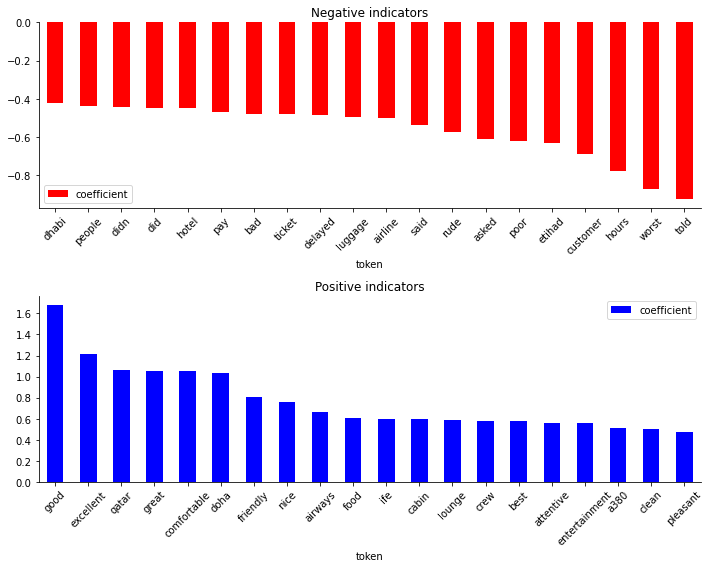

In [43]:
def plot_coefs_tfidf(logreg_tfidf, words_tfidf):
    coef_df_tfidf = pd.DataFrame({"coefficient": logreg_tfidf.coef_[0], "token": words_tfidf})
    coef_df_tfidf = coef_df_tfidf.sort_values("coefficient", ascending=False)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # smallest coefficient -> tokens indicating negative sentiment 
    coef_df_tfidf.tail(20).set_index("token").plot(kind="bar", rot=45, ax=axs[0], color="red")
    axs[0].set_title("Negative indicators")
 
    
    # largest coefficient -> tokens indicating positive sentiment 
    coef_df_tfidf.head(20).set_index("token").plot(kind="bar", rot=45, ax=axs[1], color="blue")
    axs[1].set_title("Positive indicators")
    
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
plot_coefs_tfidf(logreg_tfidf, words_tfidf)

Using the `TfidfVectorizer()` method, we do get new positive and negative words that help predict whether the review will lead to a Yes or No Recommend. However, it does look like the `TfidfVectorizer()` was able to pick up certain words like *etihad* which, based on the EDA in the previous notebook, was consistently correlated with negative experiences and scores. There's also not as many descriptive, negatively correlated words in the `TfidfVectorizer()` method as in the `CountVectorizer()`. For example, disappointed, uncomfortable, average, dirty, are some words the `TfidfVectorizer()` did not pick up. 

Negative correlated words picked up in the `TfidfVectorizer()` such as did, hotel, etihad, said, day, are not indicative of negative experiences. 

Going forward for the modelling, I will be using the `CountVectorizer()` method as this function was able to accurately pick up on key negative words that were used to describe a traveller's overall experience on the flight, regardless of airline flown. 

In [44]:
# Create a dataframe for the positive/negative sentiment words 
# Tfidf

coef_df_tfidf = pd.DataFrame({"coefficient": logreg_tfidf.coef_[0], "token": words_tfidf})
coef_df_tfidf = coef_df_tfidf.sort_values("coefficient", ascending=False)

In [45]:
# Create dataframes for the top 20 positive/negative words
tfidf_df_pos = coef_df_tfidf.head(20)
tfidf_df_neg = coef_df_tfidf.tail(20)

With that out of the way, I can now move onto creating the detailed, and various machine learning models that will attempt to predict whether a flight will be a Yes/No recommend.

### 3. Data Splitting

The first step is to split the data. I will be creating a train, validation, and test set for this process. 

In [46]:
# Create X and y variables
X = me_airlines.drop(columns=['overall','seat_comfort','cabin_service','entertainment',
                              'food_bev','ground_service','value_for_money','recommended'])
y = me_airlines['recommended']

Creating a remainder set will allow us to split the remainder set into our train and validation sets that we will use for modelling. We do not want to touch the test set until modelling arrives!

In [47]:
# Creating a chunk for the 20% test set which I'll leave to the side
X_rem, X_test, y_rem, y_test = train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               stratify=y,
                                               random_state=42)

In [48]:
# Inspect the dimensions of each data subset
print(X_rem.shape, X_test.shape, y_rem.shape, y_test.shape)

(3678, 912) (920, 912) (3678,) (920,)


I can now use the `CountVectorizer()` method to extract tokens from the `customer_review` column and later combine them with the **remainder** and **test** sets. I will also be reducing the number of features by defining a few parameters:

- the `stop_words` parameter will remove any pronouns, conjunctions, etc (i.e. words like and, is, so)
- the `min_df` parameter ignores terms that have a document frequency strictly lower than the given threshold. I have decided on `min_df=10` for this data set. So, for example, if the word 'terrific' only appears a total of 9 times in the ~2,800 rows of the remainder set, it will drop 'terrific'.
- the `max_features` parameter determines the top # number of tokens in the dataset
- the `ngram_range` parameter defines the level at which we aggregrate words (i.e. single words, word pairs).

I went with setting a `min_df=10` and `max_features=3000` as I believe 3000 words can be highly indicative of a review.

In [49]:
# Instantiate vectorizer
bagofwords = CountVectorizer(stop_words="english",
                            min_df=10,
                            max_features=3000,
                            ngram_range=(1,3))

# Fit vectorizer
bagofwords.fit(X_rem['customer_review'])

# Transform text
rem_transformed = bagofwords.transform(X_rem['customer_review'])
rem_transformed

<3678x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 224894 stored elements in Compressed Sparse Row format>

In [50]:
rem_transformed.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

I can now convert the reduced sparse matrix to a dense array for interpretation. However, I have to also tokenize the `X_test` subset in the same process.

In [51]:
# Transform the text of the test subset
test_transformed = bagofwords.transform(X_test['customer_review'])
test_transformed

<920x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 55704 stored elements in Compressed Sparse Row format>

In [52]:
# Convert the sparse matrix to dense for the remainder subset
customer_review_rem_df = pd.DataFrame(columns=bagofwords.get_feature_names(),
                                     data=rem_transformed.toarray())

customer_review_rem_df

D:\UDemy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,05,10,10 hour,10 hours,10 minutes,100,11,11 hours,...,years old,yes,yesterday,york,york jfk,young,zagreb,zero,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3676,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [53]:
# Convert the sparse matrix to dense for the test subset
customer_review_test_df = pd.DataFrame(columns=bagofwords.get_feature_names(),
                                     data=test_transformed.toarray())

customer_review_test_df

D:\UDemy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,05,10,10 hour,10 hours,10 minutes,100,11,11 hours,...,years old,yes,yesterday,york,york jfk,young,zagreb,zero,zone,zurich
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I was able to create dataframes for the remainder and test subsets. All that's left to do now is add these dataframes to the `X_rem` and `X_test` subsets respectively and drop the `customer_review` column from both subsets.

In [54]:
X_rem = pd.concat([X_rem, customer_review_rem_df.set_index(X_rem.index)], axis=1)

# Check
X_rem.head()

,customer_review,week_of_year,month_of_year,year,day_of_month,Air Arabia,Egyptair,Emirates,Etihad Airways,Gulf Air,...,years old,yes,yesterday,york,york jfk,young,zagreb,zero,zone,zurich
1415,✅ Verified Review | First Class on Qatar's A38...,18,5,2017,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
719,Me and wife flew Turkish Airlines from Toronto...,3,1,2016,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33373,✅ Verified Review | Kuwait Airways flight serv...,23,6,2017,5,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
21717,✅ Verified Review | I took an Etihad flight fr...,30,7,2016,27,0,0,0,1,0,...,0,0,0,2,0,0,0,0,0,0
1966,✅ Trip Verified | Kuala Lumpur to London via D...,12,3,2019,18,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Drop the customer review column
X_rem.drop(columns='customer_review', inplace=True)

In [56]:
X_rem.head()

,week_of_year,month_of_year,year,day_of_month,Air Arabia,Egyptair,Emirates,Etihad Airways,Gulf Air,Kuwait Airways,...,years old,yes,yesterday,york,york jfk,young,zagreb,zero,zone,zurich
1415,18,5,2017,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
719,3,1,2016,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33373,23,6,2017,5,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
21717,30,7,2016,27,0,0,0,1,0,0,...,0,0,0,2,0,0,0,0,0,0
1966,12,3,2019,18,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Do the same process for the `X_test` subset.

In [57]:
X_test = pd.concat([X_test, customer_review_test_df.set_index(X_test.index)], axis=1)

# Drop customer review column
X_test.drop(columns='customer_review', inplace=True)

# Check
X_test.head()

,week_of_year,month_of_year,year,day_of_month,Air Arabia,Egyptair,Emirates,Etihad Airways,Gulf Air,Kuwait Airways,...,years old,yes,yesterday,york,york jfk,young,zagreb,zero,zone,zurich
17887,36,9,2015,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2918,40,9,2015,29,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
21216,17,4,2019,28,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
529,48,11,2016,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
951,28,7,2015,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Before I begin modelling, I would like to see what the most common tokens are, and I will be using the `X_rem` subset.

D:\UDemy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


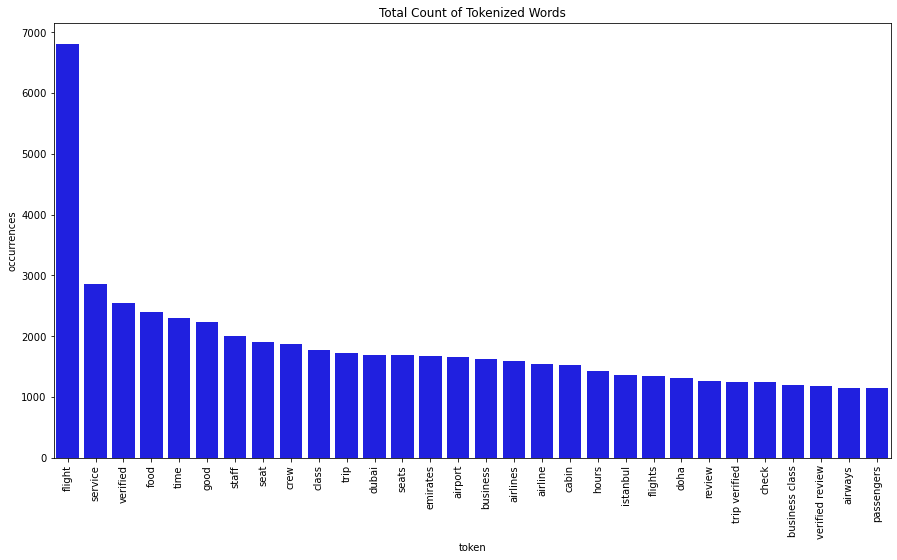

In [58]:
# Visualize the 30 most common tokens 
words = bagofwords.get_feature_names()
word_counts = rem_transformed.toarray().sum(axis=0)

X_rem_df = pd.DataFrame({"token": words,
                        "occurrences": word_counts})

X_rem_df_sorted = X_rem_df.sort_values("occurrences", ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(data = X_rem_df_sorted.head(30), x="token", y="occurrences", color="blue")
plt.title('Total Count of Tokenized Words')
plt.xticks(rotation=90)
plt.show()

It looks like 'flight' was the most used token in the Middle Eastern carriers dataframe by far, followed by service, verified, food, time, etc. This visual doesn't inform us whether those words are associated with either a positive/negative review (this step is done earlier). However, I do see a few, possible negative tokens in there (i.e. etihad). 

With the subsets taken care of, I can now move onto the Modelling section of this report. The first step here is to split the `remainder` subset into a train and validation set.

In [59]:
# Split the remainder subset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rem,
                                                 y_rem,
                                                 test_size=0.3,
                                                  stratify=y_rem,
                                                 random_state=42)

In [60]:
# Check shapes
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2574, 3911) (1104, 3911) (2574,) (1104,)


It is clear the number of features that were added in the previous step were not affected by this split, and we are left with Train data set of 1948 rows by 3832 columns, and a Validation data set of 836 rows by 3832 columns.

#### Scaling Data

All models - except the Decision Tree Classifier - are distance-based algorithms. Therefore, I will transform all data subsets using the `MinMaxScaler`. I have selected this scaler because I am not looking to change the distribution of the data, but to make sure all feature distributions are shrunk to fit between 0 and 1.

In [61]:
# Instantiate Scaler
scaler = MinMaxScaler()

# Fit to X_train and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform other subsets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### 4. Modelling

#### Model 4.1 - Logistic Regression

My first iteration of a Logistic Regression will be a basic one, with no specified metrics.

In [62]:
# Check default solver
log_reg1 = LogisticRegression(random_state=42)

log_reg1.solver

'lbfgs'

In [63]:
# Instantiate and fit basic Logistic Regression model
log_reg1.fit(X_train_scaled, y_train)

# Model performance with train and validation data
log_reg1_train_acc = log_reg1.score(X_train_scaled, y_train)
log_reg1_val_acc = log_reg1.score(X_val_scaled, y_val)

print(f"Train accuracy: {round(log_reg1_train_acc,4)}")
print(f"Validation accuracy: {round(log_reg1_val_acc,4)}")

Train accuracy: 0.9938
Validation accuracy: 0.8569


It can be seen that both the Train and Validation sets performed extremely well. The Train accuracy (99.38%) is ~14% percentage points higher than the Validation accuracy (85.69%). This means that there is overfitting in the model. One way to reduce the overfitting is through hyperparameter optimization.

#### Hyperparameter Optimization

I want to spend some time on hyperparameter optimization of the Logistic Regression. The `C` parameter for a Logistic Regression controls the regularization strength of the model where lower `C` values allow greater errors.

C=0.0001 completed
C=0.001 completed
C=0.01 completed
C=0.1 completed
C=1 completed
C=10 completed
C=100 completed
C=1000 completed


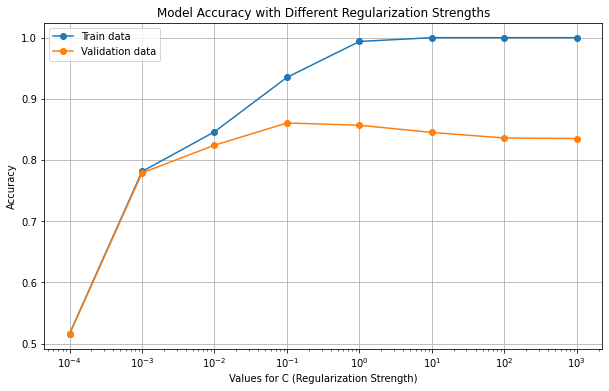

In [64]:
# Values of C to iterate over
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Empty lists to store accuracy scores
train_acc = []
val_acc = []

# Loop model iteration across all C-values
for C in C_values:
    logit_C = LogisticRegression(random_state=42, max_iter=3000, C=C).fit(X_train_scaled, y_train)
    train_acc.append(logit_C.score(X_train_scaled, y_train))
    val_acc.append(logit_C.score(X_val_scaled, y_val))
    print(f"C={C} completed")
    
# Visualize accuracy scores across C-values
plt.figure(figsize=(10,6))
plt.plot(C_values, train_acc, marker='o', label='Train data')
plt.plot(C_values, val_acc, marker='o', label='Validation data')
plt.xscale('log')
plt.xlabel('Values for C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy with Different Regularization Strengths')
plt.grid()

plt.show()

Usually, the default `C` is 1. In the case above, the highest Validation accuracy occurs at `C=0.1`. However, the model has less overfitting occurring when `C=0.01`. In this case, I have decided to go with `C=0.1` because the smaller the C-value, the greater the error is, and based on the visual above, there is only slightly more overfitting when `C=0.1` compared to when `C=0.01`.

In [65]:
# Instantiate model
log_reg2 = LogisticRegression(random_state=42, max_iter=3000, C=0.1).fit(X_train_scaled, y_train)

# Score model against data subsets
log_reg2_train_acc = log_reg2.score(X_train_scaled, y_train)
log_reg2_val_acc = log_reg2.score(X_val_scaled, y_val)
log_reg2_test_acc = log_reg2.score(X_test_scaled, y_test)

print(f"Train Accuracy: {round(log_reg2_train_acc,4)*100}%")
print(f"Validation Accuracy: {round(log_reg2_val_acc,4)*100}%")
print(f"Test Accuracy: {round(log_reg2_test_acc,4)*100}%")

Train Accuracy: 93.51%
Validation Accuracy: 86.05000000000001%
Test Accuracy: 86.41%


I have managed to reduce the overfitting between the train and test/validation sets significantly. This means the model is more generalized. And with the Validation and Test accuracies relatively close, it looks like minimal data leakage has occurred. 

Next let me check the classification report.

D:\UDemy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.86      0.86      0.86       446
           1       0.87      0.87      0.87       474

    accuracy                           0.86       920
   macro avg       0.86      0.86      0.86       920
weighted avg       0.86      0.86      0.86       920



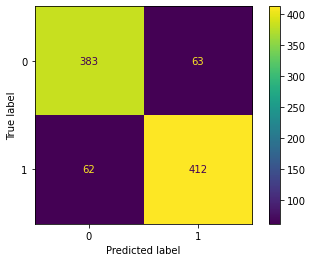

In [66]:
# Model predictions on test data
y_pred = log_reg2.predict(X_test_scaled)

# Call confusion matrix
plot_confusion_matrix(log_reg2, X_test_scaled, y_test, cmap='viridis')

print(classification_report(y_test, y_pred))

The classification report is summarized as follows:

- There are **412** True Positives and **383** True Negatives, adding up to ~86% model accuracy. This means that the model correctly predicted 303 reviews that gave a 'Yes' recommendation, and correctly predicted 290 reviews that gave a 'No' recommendation. 
- False positives (Type I errors) make up ~6.8% of predictions. This means that the model incorrectly predicted 63 reviews that gave a 'Yes' recommendation.
- False negatives (Type II errors) make up ~7.9% of predictions. This means that the model incorrectly predicted 62 reviews that gave a 'No' recommendation.
- The precision (positive predictive) value is 87%. This means that 87% of all Class 1 predictions were 'actual' class 1.
- The recall (true positive) rate is 87%. This means that 87% of 'actual' Class 1 were predicted correctly.

The next step I'd like to try is reducing the dimensionality of the data using Principal Component Analysis (PCA). I'd like to see if the model can still produce an accurate result as well as a classification report if some of the dimensions are dropped. 

##### Logistic Regression - PCA

In [67]:
# Instantiate PCA model
pca_method = PCA()

# Fit PCA to scaled data
pca_method.fit(X_train_scaled)

PCA()

I'd like to maintain 80% of the variance in the dataset. To see how many components I'll need to achieve this, I'll be producing a plot that displays the cumulative explained variance of Principal Components.

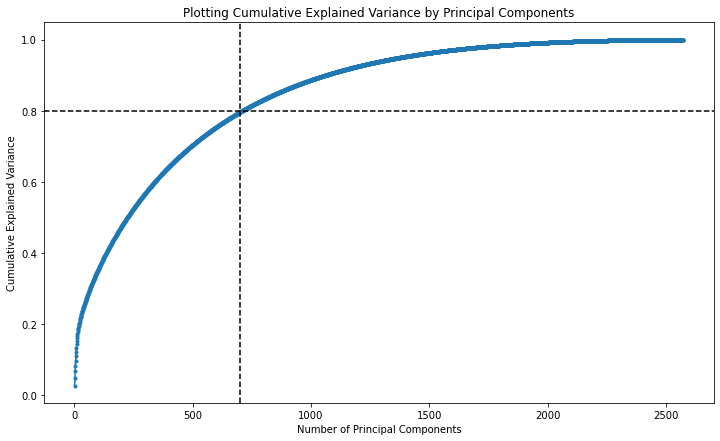

In [70]:
explained_variance = pca_method.explained_variance_ratio_

# Plot the figure
plt.figure(figsize=(12,7))

plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='.')
plt.axhline(0.8, color='black', linestyle='--')
plt.axvline(700, color='black', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Plotting Cumulative Explained Variance by Principal Components')

plt.show()

It looks like the optimal number of Principal Components is needed to achieve around 80% variance is ~700 Principal Components. In order to make sure that this is the right number of components, we could apply a parameter value to the `PCA` function to find the minimum number of components needed. 

In [71]:
# Fit the new PCA parameter
pca_method = PCA(n_components=0.8)

pca_method.fit(X_train_scaled)

# Transform each data subset
X_train_pca = pca_method.transform(X_train_scaled)
X_val_pca = pca_method.transform(X_val_scaled)
X_test_pca = pca_method.transform(X_test_scaled)

In [72]:
pca_method.n_components_

710

Now we can run the same hyperparameter optimization Logistic Regression model with the scaled PCA data.

C=0.0001 completed
C=0.001 completed
C=0.01 completed
C=0.1 completed
C=1 completed
C=10 completed
C=100 completed
C=1000 completed


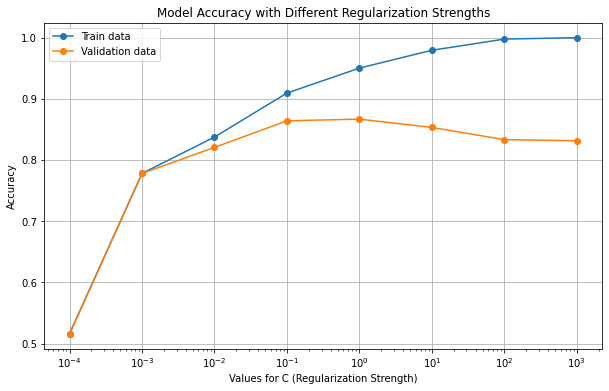

In [73]:
# Values of C to iterate over
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Empty lists to store accuracy scores
train_acc_pca = []
val_acc_pca = []

# Loop model iteration across all C-values
for C in C_values:
    logit_C = LogisticRegression(random_state=42, max_iter=3000, C=C).fit(X_train_pca, y_train)
    train_acc_pca.append(logit_C.score(X_train_pca, y_train))
    val_acc_pca.append(logit_C.score(X_val_pca, y_val))
    print(f"C={C} completed")
    
# Visualize accuracy scores across C-values
plt.figure(figsize=(10,6))
plt.plot(C_values, train_acc_pca, marker='o', label='Train data')
plt.plot(C_values, val_acc_pca, marker='o', label='Validation data')
plt.xscale('log')
plt.xlabel('Values for C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy with Different Regularization Strengths')
plt.grid()

plt.show()

It appears that `C=0.1` looks to be a good choice again.

In [74]:
# Instantiate model
log_reg3 = LogisticRegression(random_state=42, max_iter=3000, C=0.1).fit(X_train_pca, y_train)

# Score model against data subsets
log_reg3_train_acc = log_reg3.score(X_train_pca, y_train)
log_reg3_val_acc = log_reg3.score(X_val_pca, y_val)
log_reg3_test_acc = log_reg3.score(X_test_pca, y_test)

print(f"Train Accuracy: {round(log_reg3_train_acc,4)*100}%")
print(f"Validation Accuracy: {round(log_reg3_val_acc,4)*100}%")
print(f"Test Accuracy: {round(log_reg3_test_acc,4)*100}%")

Train Accuracy: 90.95%
Validation Accuracy: 86.41%
Test Accuracy: 86.2%


Let's create a table that displays all the accuracy scores for the original scaled data, and the pca scaled data.

In [75]:
pd.DataFrame({'3911 Dimensions': [log_reg2_train_acc, log_reg2_val_acc, log_reg2_test_acc],
                 '710 Dimensions': [log_reg3_train_acc, log_reg3_val_acc, log_reg3_test_acc]},
            index = ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])

,3911 Dimensions,710 Dimensions
Train Accuracy,0.935120,0.909479
Validation Accuracy,0.860507,0.864130
Test Accuracy,0.864130,0.861957


Amazingly there isn't significant difference between any of the datasets once the dimensions were greatly reduced. While the Train Accuracy did fall ~2.5% points, there was an increase in the Validation Accuracy, from 86.0% to 86.4%. However, the Test Accuracy saw a decrease of ~0.3% points. I would say the PCA Logistic Regression is more generalized than the original Logistic Regression model as there is less overfitting occurring between the Test and Train data sets. 

However, PCA doesn't come without risks. Implementing the PCA method on a dataset runs the risk of information loss and reduced interpretability of independent variables. Due to this issue, I will be sticking with the original scaled Logistic Regression model as it takes all dimensions into account.

Next I will be creating a model using KNNs.

#### Model 4.2 - K Nearest Neighbor Classifier

I will now be experimenting with a KNN model to see if I get better, worse, or similar results as I did with Logistic Regression. The first step is conducting a simple, plain KNN model.

In [76]:
# Simple KNN with no hyperparamter optimization
my_knn = KNeighborsClassifier()

my_knn.fit(X_train_scaled, y_train)
print(f"Training Accuracy: {my_knn.score(X_train_scaled, y_train)}")
print(f"Validation Accuracy: {my_knn.score(X_val_scaled, y_val)}")

Training Accuracy: 0.782051282051282
Validation Accuracy: 0.6784420289855072


There is quite a bit of overfitting between the Train and Validation sets, and the accuracies aren't as good as those for the Logistic Regression modelling, but I will see if I can improve on them through hyperparameter optimization.

In [77]:
k_values = np.arange(1, 101, 2)

# Empty lists for metrics
knn_train_acc = []
knn_val_acc = []

# Iterate over different 'k' values
for k in k_values:
    
    my_knn = KNeighborsClassifier(n_neighbors=k)
    my_knn.fit(X_train_scaled, y_train)
    knn_train_acc.append(my_knn.score(X_train_scaled, y_train))
    knn_val_acc.append(my_knn.score(X_val_scaled, y_val))
    
    print(f"{k} nearest neighbors modelled", end='\r')
    

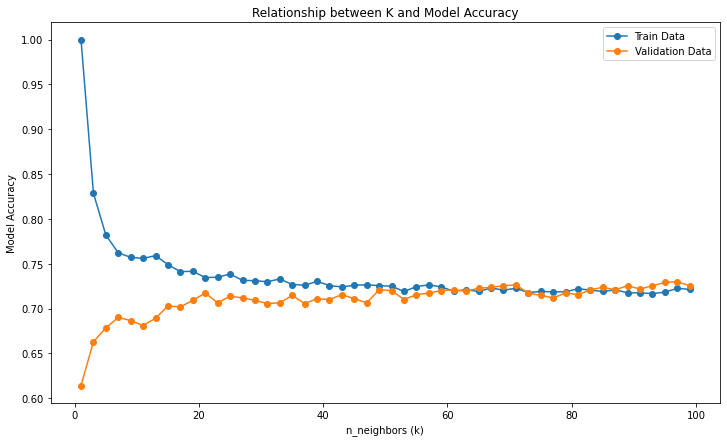

In [78]:
# Visualize relationship between 'k' and model accuracy
plt.figure(figsize=(12,7))
plt.plot(k_values, knn_train_acc, marker='o', label='Train Data')
plt.plot(k_values, knn_val_acc, marker='o', label='Validation Data')
plt.legend()
plt.xlabel('n_neighbors (k)')
plt.ylabel('Model Accuracy')
plt.title('Relationship between K and Model Accuracy')

plt.show()

It can be seen that the Train and Validation sets eventually plateau at around 75%, indicating minimal overfitting on the Validation set's part. However, to find the optimal `k` value, I can employ a pipeline method that can will also make use of cross-validation.

In [79]:
# Instantiate KNeighbors Transformer 
knn_transformer = KNeighborsTransformer(mode='distance', n_neighbors=101)
knn_classifier = KNeighborsClassifier(metric='precomputed')

# Put in pipeline
knn_pipeline = Pipeline([('scaler', MinMaxScaler()),
                           ('transformer', knn_transformer),
                           ('classifier', knn_classifier)],
                         )

# Set up the grid search
grid_params = {'classifier__n_neighbors':k_values}

# Instantiate
my_gridsearch = GridSearchCV(knn_pipeline, grid_params, verbose=1, cv=3)

# Fit
my_gridsearch.fit(X_rem, y_rem)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('transformer',
                                        KNeighborsTransformer(n_neighbors=101)),
                                       ('classifier',
                                        KNeighborsClassifier(metric='precomputed'))]),
             param_grid={'classifier__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
             verbose=1)

Let's check out what the best parameters are to use for the optimal KNN model.

In [80]:
# Find out best parameters
my_gridsearch.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('transformer', KNeighborsTransformer(n_neighbors=101)),
                ('classifier',
                 KNeighborsClassifier(metric='precomputed', n_neighbors=99))])

It appears the optimal `k` value occurs when the `n_neighbors=99`. Therefore, in the next iteration of the optimal knn model, I will use `n_neighbors=99`. 

In [81]:
my_knn_optimal = KNeighborsClassifier(n_neighbors=99)

my_knn_optimal.fit(X_train_scaled, y_train)

knn_optimal_train = my_knn_optimal.score(X_train_scaled, y_train)
knn_optimal_val = my_knn_optimal.score(X_val_scaled, y_val)
knn_optimal_test = my_knn_optimal.score(X_test_scaled, y_test)

print("Optimized KNN Model")
print(f"Train Accuracy: {knn_optimal_train}")
print(f"Validation Accuracy: {knn_optimal_val}")
print(f"Test Accuracy: {knn_optimal_test}")

Optimized KNN Model
Train Accuracy: 0.7214452214452215
Validation Accuracy: 0.7255434782608695
Test Accuracy: 0.7054347826086956


It looks like when `k=99`, I get my best Test Accuracy score of 70.54%, which is only ~1.6% point lower than Train Accuracy score, indicating low overfitting. An added bonus is that when the optimal `n_neighbors=99` the validation accuracy has increased, and the KNN model has much less overfitting occurring compared to the Logistic Regression model. 

Next we'll see how the model predictions faired. 

D:\UDemy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.75      0.59      0.66       446
           1       0.68      0.82      0.74       474

    accuracy                           0.71       920
   macro avg       0.71      0.70      0.70       920
weighted avg       0.71      0.71      0.70       920



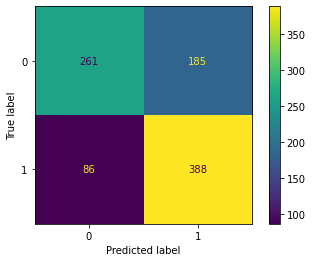

In [82]:
# Model predictions on test data
y_pred_knn = my_knn_optimal.predict(X_test_scaled)

# Call confusion matrix
plot_confusion_matrix(my_knn_optimal, X_test_scaled, y_test, cmap='viridis')

print(classification_report(y_test, y_pred_knn))

It can be seen that the KNN model did not perform as well as the Logistic Regression model. The KNN classification report is summarized as follows:

- There are **388** True Positives and **261** True Negatives, adding up to ~70% model accuracy. This means that the model correctly predicted 388 reviews that gave a 'Yes' recommendation, and correctly predicted 261 reviews that gave a 'No' recommendation. 
- False positives (Type I errors) make up ~20.1% of predictions. This means that the model incorrectly predicted 185 reviews that gave a 'Yes' recommendation.
- False negatives (Type II errors) make up ~9.3% of predictions. This means that the model incorrectly predicted 86 reviews that gave a 'No' recommendation.
- The precision (positive predictive) value is 68%. This means that 68% of all Class 1 predictions were 'actual' class 1.
- The recall (true positive) rate is 82%. This means that 82% of 'actual' Class 1 were predicted correctly.

Compared to the Logistic Regression model, the precision percentage is significantly lower, but they the recall score is relatively good. It doesn't look good for the KNN model as it predicted a large amount of False Positives, which can be misleading for travellers and airlines alike if this model was used. 

#### Model 4.3 - Decision Tree Classifier

In [83]:
# Instantiate basic model
dtree = DecisionTreeClassifier()

# Fit and score 
dtree.fit(X_train_scaled, y_train)
print(f"Train Accuracy: {dtree.score(X_train_scaled, y_train)}")
print(f"Validation Accuracy: {dtree.score(X_val_scaled, y_val)}")

Train Accuracy: 1.0
Validation Accuracy: 0.7653985507246377


The basic Decision Tree model provides a validation accuracy of 75% and a train accuracy 0f 100% which doesn't tell us a lot. Let's try conducting a bit more hyperparameter optimization by exploring how the model performs with varioud `max_depth` values.

In [84]:
# Levels of splitting to test
max_depths = [2,3,4,5,6,7,8,9,10,11,12,13,14]

# Empty lists for metrics
dtree_train_acc = []
dtree_val_acc = []

# Iterate over parameter values
for max_depth in max_depths:
    dtree_md = DecisionTreeClassifier(max_depth=max_depth)
    dtree_md.fit(X_train_scaled, y_train)
    
    dtree_train_acc.append(dtree_md.score(X_train_scaled, y_train))
    dtree_val_acc.append(dtree_md.score(X_val_scaled, y_val))
    
    print(f"Completed max_depth={max_depth}", end='\r')

Plot the results

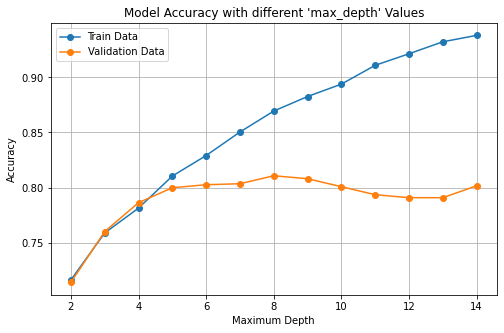

In [85]:
# Plot the figure
plt.figure(figsize=(8,5))

plt.plot(max_depths, dtree_train_acc, marker='o', label='Train Data')
plt.plot(max_depths, dtree_val_acc, marker='o', label='Validation Data')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title("Model Accuracy with different 'max_depth' Values")
plt.legend()
plt.grid()
plt.show()

As the train accuracy increases, the validation accuracy seems to plateau around 80%. I will be picking a `max_depth=5` as that depth provides a good accuracy with the least amount of overfitting.

In [86]:
# Use the optimal max depth
dtree2 = DecisionTreeClassifier(max_depth=5)

dtree2.fit(X_train_scaled, y_train)

dtree2_train_acc = dtree2.score(X_train_scaled, y_train)
dtree2_val_acc = dtree2.score(X_val_scaled, y_val)
dtree2_test_acc = dtree2.score(X_test_scaled, y_test)

print(f"Train Accuracy: {round(dtree2_train_acc, 4)*100}%")
print(f"Validation Accuracy: {round(dtree2_val_acc, 4)*100}%")
print(f"Test Accuracy: {round(dtree2_test_acc, 4)*100}%")

Train Accuracy: 81.04%
Validation Accuracy: 79.89%
Test Accuracy: 76.2%


The Decision Tree model is more generalized now. We have brought down the accuracy of the train set significantly while increasing the validation accuracy. The Test set performed decently well, presenting an accuracy score of 76%. We can next check the model predictions of the Decision Tree.

D:\UDemy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.75      0.75       446
           1       0.77      0.77      0.77       474

    accuracy                           0.76       920
   macro avg       0.76      0.76      0.76       920
weighted avg       0.76      0.76      0.76       920



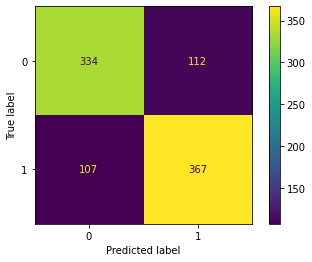

In [87]:
# Model predictions on test data
y_pred_dtree = dtree2.predict(X_test_scaled)

# Call confusion matrix
plot_confusion_matrix(dtree2, X_test_scaled, y_test, cmap='viridis')

print(classification_report(y_test, y_pred_dtree))

The Decision Tree model performs slightly better than the KNN model, but not as good as the Logistic Regression mode. The Decision Tree model classification report is summarized as follows:

- There are **367** True Positives and **334** True Negatives, adding up to ~76% model accuracy. This means that the model correctly predicted 367 reviews that gave a 'Yes' recommendation, and correctly predicted 334 reviews that gave a 'No' recommendation. 
- False positives (Type I errors) make up ~12.2% of predictions. This means that the model incorrectly predicted 112 reviews that gave a 'Yes' recommendation.
- False negatives (Type II errors) make up ~11.6% of predictions. This means that the model incorrectly predicted 107 reviews that gave a 'No' recommendation.
- The precision (positive predictive) value is 77%. This means that 77% of all Class 1 predictions were 'actual' class 1.
- The recall (true positive) rate is 77%. This means that 77% of 'actual' Class 1 were predicted correctly.

We see better precision and recall scores for the Decision Tree model, with both at 77%. This is great news as, in terms of recall, the model is not missing many class members. However, the Logistic Regression model has a precision and recall score of 87% respectively.

When it comes to predicting airline Yes/No recommendations from airline reviews, a higher precision AND recall score would ensure the airlines' executives are receiving accurate data that will help them address certain issues in areas where they can improve on, and maintain consistent standards in areas where they are performing well.

#### Model 4.4 - Support Vector Machines

I have decided to also experiment with a SVM model to see if it can perform better than a Logistic Regression model. The two are similar in certain ways, such that both models learn linear decision boundaries. However, SVM model's goal is to find the boundary which is in the middle of the two classes, maximizing the distance between the decision boundary and the closest points from the training data.

Whereas a Logistic Regression model takes a probabilistic approach and aims to maximize the likelihood of the training data given the parameters. 

So let's see whether a SVM model can perform just as well, if not better, than the Logistic Regression model.

In [88]:
# Instantiate basic model
SVM_model = LinearSVC()

# Fit and score 
SVM_model.fit(X_train_scaled, y_train)
print(f"Train Accuracy: {SVM_model.score(X_train_scaled, y_train)}")
print(f"Validation Accuracy: {SVM_model.score(X_val_scaled, y_val)}")

Train Accuracy: 1.0
Validation Accuracy: 0.8297101449275363


No surprise that the Train Accuracy is 100%, but we do have a decent start with the Validation Accuracy of 82.97%. Next we'll apply hyperparameter optimization to see what the best C candidate is.

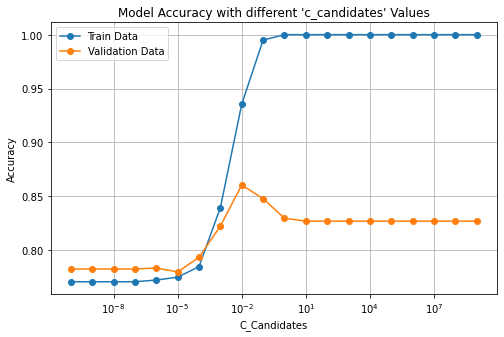

In [89]:
# SVM 
c_candidates = 10**np.arange(-10.0,10.0)

svm_train_acc = []
svm_val_acc = []

# Loop through
for c in c_candidates:
    
    SVM_model = LinearSVC(C=c)
    SVM_model.fit(X_train_scaled, y_train)
    
    svm_train_acc.append(SVM_model.score(X_train_scaled, y_train))
    svm_val_acc.append(SVM_model.score(X_val_scaled, y_val))
    
plt.figure(figsize=(8,5))

plt.plot(c_candidates, svm_train_acc, marker='o', label='Train Data')
plt.plot(c_candidates, svm_val_acc, marker='o', label='Validation Data')
plt.xlabel('C_Candidates')
plt.ylabel('Accuracy')
plt.title("Model Accuracy with different 'c_candidates' Values")
plt.legend()
plt.xscale('log')
plt.grid()
plt.show()

The Train set eventually increases 100% accuracy when the `C_candidate=~0.1` whereas the Validation set peaks at `C_candidate=0.01` and then plateaus at ~83%.

In [90]:
# Instantiate basic model
SVM_model = LinearSVC(random_state=42, max_iter=3000, C=0.01)

# Fit and score 
SVM_model.fit(X_train_scaled, y_train)
print(f"Train Accuracy: {SVM_model.score(X_train_scaled, y_train)}")
print(f"Validation Accuracy: {SVM_model.score(X_val_scaled, y_val)}")
print(f"Test Accuracy: {SVM_model.score(X_test_scaled, y_test)}")

Train Accuracy: 0.9355089355089355
Validation Accuracy: 0.8605072463768116
Test Accuracy: 0.8608695652173913


We were able to reduce the overfitting, creating a more generalized model, but there is more overfitting with the SVM model compared to the Decision Tree and KNN models, and just slightly more overfitting than the Logistic Regression model. 

Next let's see the classification report for the SVM model.

D:\UDemy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.86      0.85      0.86       446
           1       0.86      0.87      0.87       474

    accuracy                           0.86       920
   macro avg       0.86      0.86      0.86       920
weighted avg       0.86      0.86      0.86       920



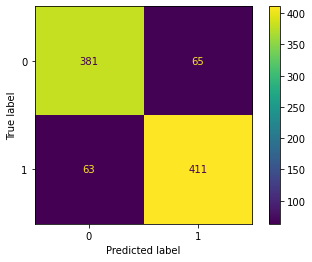

In [91]:
# Model predictions on test data
y_pred_svm = SVM_model.predict(X_test_scaled)

# Call confusion matrix
plot_confusion_matrix(SVM_model, X_test_scaled, y_test, cmap='viridis')

print(classification_report(y_test, y_pred_svm))

The SVM model performs better than the KNN and Decision Tree models, but and is comparable to the Logistic Regression model. The SVM model classification report is summarized as follows:

- There are **411** True Positives and **381** True Negatives, adding up to ~86% model accuracy. This means that the model correctly predicted 411 reviews that gave a 'Yes' recommendation, and correctly predicted 381 reviews that gave a 'No' recommendation. 
- False positives (Type I errors) make up ~6.9% of predictions. This means that the model incorrectly predicted 65 reviews that gave a 'Yes' recommendation.
- False negatives (Type II errors) make up ~7.9% of predictions. This means that the model incorrectly predicted 63 reviews that gave a 'No' recommendation.
- The precision (positive predictive) value is 86%. This means that 86% of all Class 1 predictions were 'actual' class 1.
- The recall (true positive) rate is 87%. This means that 87% of 'actual' Class 1 were predicted correctly.

Based on the numbers, there isn't much difference in model performance between the Logistic Regression and SVM models. The only difference is that the Logistic Regression model has a slightly better test accuracy score, as well as a slightly better precision score. 

#### Conclusions

In this notebook we performed Natural Language Processing on airline customer reviews using 4 machine learning models. These 4 models were Logistic Regression (with PCA), K-Nearest Neighbors, Decision Trees and Support Vector Machine (SVM). I performed various hyperparameter optimization techniques for all the machine learning methods to find the optimal `k`, `c`, `c_candidate` and `max_depth` for each model, using for loops for all of them. I also applied Principal Component Analysis to the Logistic Regression model to see whether dimension reduction would produce a positive outcome on the Logistic Regression model. 

After performing an analysis and comparing the precision and recall scores of each model, I have decided to go forward with with the Logistic Regression model. It produces the highest precision and recall scores of 87% respectively, with SVM having a slightly less precision score.

A precision and recall score of 87% each is great since the model accurately identifies points that do actually belong to a specific class, and does not miss identifying many class members. This means that the Logistic Regression model is accurately predicting which reviews lead to a yes/no recommend, and is doing so with missing only a minimal amount of class members. It also has a slightly better test accuracy than the SVM model (86.4% to 86.1). The difference is small, but the higher the accuracy, the higher the better chances of predicting which reviews led to a yes/no recommendation.